In [1]:
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit

import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output

In [2]:
# Set random seed for reproducibility
seed = 600
random.seed(seed)
np.random.seed(seed)

### Dataset

In [3]:
dataset = pd.read_csv('creditcard.csv')

In [4]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
dataset.drop('Time', axis = 1, inplace=True)
dataset.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
dataset.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [7]:
dataset.isna().sum().sum()

0

In [8]:
dataset.duplicated().sum()

9144

In [9]:
print(f'dimensões antes de remover linhas duplicadas:{dataset.shape}')

dimensões antes de remover linhas duplicadas:(284807, 30)


In [10]:
dataset.drop_duplicates(inplace=True)

In [11]:
print(f'dimensões após de remover linhas duplicadas:{dataset.shape}')

dimensões após de remover linhas duplicadas:(275663, 30)


In [12]:
dataset.reset_index(drop=True, inplace=True)

In [13]:
target = dataset.Class.values
data = dataset.drop(labels=['Class'], axis=1).values

In [14]:
data.shape

(275663, 29)

### Treino

In [15]:
n_trials = 5
metrics_iso = {}
metrics_lof = {}
out_columns = len(target)
contamination = [0.1, 0.2, 0.3, 0.4, 0.5, 'auto']

levels_2 = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.25, 0.5, 0.75, 1] 

# Training loop
splitter = StratifiedShuffleSplit(n_splits=n_trials, test_size=0.2, random_state=seed)
start = time.time()

for i, contamination in enumerate(contamination):
    print(f'Teste {i+1}. Contaminação: {contamination}')
    # Inicialização das matrizes com os resultados
    ResultAcc_Iso = [[0] * n_trials for _ in range(len(levels_2))]
    ResultF1_Iso = [[0] * n_trials for _ in range(len(levels_2))]
    Resultprecision_Iso = [[0] * n_trials for _ in range(len(levels_2))]
    Resultrecall_Iso = [[0] * n_trials for _ in range(len(levels_2))]
    
    
    ResultAcc_LOF = [[0] * n_trials for _ in range(len(levels_2))]
    ResultF1_LOF = [[0] * n_trials for _ in range(len(levels_2))]
    Precision_LOF = [[0] * n_trials for _ in range(len(levels_2))]
    Recall_LOF = [[0] * n_trials for _ in range(len(levels_2))]

    for j, level in enumerate(levels_2):
        print(f'\t step {j+1}/{len(levels_2)}')
        for k, (train_index, test_index) in enumerate(splitter.split(data, target)):
            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = target[train_index], target[test_index]

            # Separation between normal and anomalous data for training
            NormalData = X_train[y_train == 0, :]
            AnomData = X_train[y_train == 1, :]

            # Percentage of normal data included in training
            NormTrainSize = round(level * len(NormalData))
            RedNormTrainData = NormalData[np.random.choice(NormalData.shape[0], size=NormTrainSize, replace=False), :]

            # Training data including both normal and anomalous data (contaminated training data)
            DataTrain = np.concatenate((AnomData, RedNormTrainData), axis=0)
            # print(f'shape train: {DataTrain.shape} | shape test: {X_test.shape} ')
            # Shuffling Train Dataset
            shuffle_obj = np.random.default_rng(seed)
            DataTrain = shuffle_obj.permutation(DataTrain, axis=0)

            # Instanciating isolation forest
            isolation_clf = IsolationForest(n_estimators=100,
                                            max_samples=out_columns,
                                            contamination=contamination,
                                            n_jobs=-1,
                                            random_state=seed,
                                            verbose=0)

            isolation_clf.fit(DataTrain)
            y_pred_iso = isolation_clf.predict(X_test)

            #Computing metrics
            ## The term abs((y_pred-1)/2) is used because the isolation forest provides results -1 and 1 instead of 1 and 0
            ResultAcc_Iso[j][k] = accuracy_score(y_test, abs((y_pred_iso-1)/2))
            ResultF1_Iso[j][k] = f1_score(y_test, abs((y_pred_iso-1)/2))
            Resultrecall_Iso[j][k] = recall_score(y_test, abs((y_pred_iso-1)/2))
            Resultprecision_Iso[j][k] = precision_score(y_test, abs((y_pred_iso-1)/2))
            
            # testando o neighbors 5, 10 e 20
            lof_clf = LocalOutlierFactor(n_neighbors=10,
                                     algorithm='auto',
                                     contamination=contamination,
                                     novelty=True,
                                     n_jobs=-1)

            lof_clf.fit(DataTrain)
            y_pred_lof = lof_clf.predict(X_test)

            ResultAcc_LOF[j][k] = accuracy_score(y_test, abs((y_pred_lof-1)/2))
            ResultF1_LOF[j][k] = f1_score(y_test, abs((y_pred_lof-1)/2))
            Precision_LOF[j][k] = precision_score(y_test, abs((y_pred_lof-1)/2))
            Recall_LOF[j][k] = recall_score(y_test, abs((y_pred_lof-1)/2))

    clear_output(wait=True)

    metrics_iso[i] = {'acc': ResultAcc_Iso,
                  'f1': ResultF1_Iso,
                  'recall': Resultrecall_Iso,
                  'precision': Resultprecision_Iso
                }

    metrics_lof[i] = {'acc': ResultAcc_LOF,
                  'f1': ResultF1_LOF,
                  'recall': Precision_LOF,
                  'precision': Recall_LOF
                }
end = time.time()
print(f'Training Finished. Elapsed time = {(end-start)/60:.2f} minutes.')


Training Finished. Elapsed time = 81.58 minutes.


In [33]:
for i in range(6):
    filename = f'cont_iso{i}_csv'
    df_iso = pd.DataFrame.from_dict(metrics_iso[i])
    df_iso.insert(0, 'levels', levels_2)
    df_iso.to_csv(filename, index=False)
df_iso

,levels,acc,f1,recall,precision
0,0.05,"[0.9943772332359929, 0.9946130266809352, 0.995...","[0.11931818181818182, 0.13411078717201166, 0.1...","[0.22105263157894736, 0.24210526315789474, 0.2...","[0.08171206225680934, 0.09274193548387097, 0.1..."
1,0.06,"[0.9952478551865489, 0.9944860609798124, 0.994...","[0.12666666666666665, 0.16483516483516483, 0.1...","[0.2, 0.3157894736842105, 0.24210526315789474,...","[0.09268292682926829, 0.11152416356877323, 0.0..."
2,0.07,"[0.9953566829303684, 0.9955562004607041, 0.995...","[0.15231788079470196, 0.18060200668896323, 0.1...","[0.24210526315789474, 0.28421052631578947, 0.2...","[0.1111111111111111, 0.1323529411764706, 0.110..."
3,0.08,"[0.994812544211271, 0.9954292347595813, 0.9951...","[0.13855421686746988, 0.19230769230769232, 0.1...","[0.24210526315789474, 0.3157894736842105, 0.29...","[0.0970464135021097, 0.1382488479262673, 0.121..."
4,0.09,"[0.9953748208876716, 0.9954473727168847, 0.995...","[0.12371134020618556, 0.17704918032786884, 0.1...","[0.18947368421052632, 0.28421052631578947, 0.2...","[0.09183673469387756, 0.12857142857142856, 0.1..."
5,0.10,"[0.9950483376562131, 0.9956287522899171, 0.995...","[0.14953271028037385, 0.18305084745762712, 0.1...","[0.25263157894736843, 0.28421052631578947, 0.2...","[0.10619469026548672, 0.135, 0.142857142857142..."
6,0.25,"[0.9965356501550795, 0.9961184771371048, 0.996...","[0.18723404255319148, 0.23021582733812948, 0.2...","[0.23157894736842105, 0.3368421052631579, 0.30...","[0.15714285714285714, 0.17486338797814208, 0.1..."
7,0.50,"[0.9968984093011445, 0.9967714436000218, 0.996...","[0.25327510917030566, 0.31007751937984496, 0.2...","[0.30526315789473685, 0.42105263157894735, 0.3...","[0.21641791044776118, 0.24539877300613497, 0.2..."
8,0.75,"[0.997007237044964, 0.9970979268314802, 0.9971...","[0.2465753424657534, 0.31034482758620696, 0.26...","[0.28421052631578947, 0.37894736842105264, 0.3...","[0.21774193548387097, 0.26277372262773724, 0.2..."
9,1.00,"[0.9971886166179965, 0.9970253750022673, 0.997...","[0.2512077294685991, 0.27433628318584075, 0.28...","[0.2736842105263158, 0.3263157894736842, 0.336...","[0.23214285714285715, 0.2366412213740458, 0.24..."


In [34]:
for i in range(6):
    filename = f'cont_lof{i}_csv'
    df_lof = pd.DataFrame.from_dict(metrics_lof[i])
    df_lof.insert(0, 'levels', levels_2)
    df_lof.to_csv(filename, index=False)
df_lof

,levels,acc,f1,recall,precision
0,0.05,"[0.9581557325014057, 0.957085593020514, 0.9554...","[0.018715440238196514, 0.018257261410788383, 0...","[0.00975177304964539, 0.009503239740820735, 0....","[0.23157894736842105, 0.23157894736842105, 0.2..."
1,0.06,"[0.9541835198519942, 0.9584640777755609, 0.958...","[0.018648018648018648, 0.018010291595197254, 0...","[0.009681323114158934, 0.009387572641931158, 0...","[0.25263157894736843, 0.22105263157894736, 0.2..."
2,0.07,"[0.9570493171059076, 0.9577748353980374, 0.955...","[0.020678246484698095, 0.017721518987341773, 0...","[0.01076194575979337, 0.009230769230769232, 0....","[0.2631578947368421, 0.22105263157894736, 0.25..."
3,0.08,"[0.9587542850924129, 0.9552173834182794, 0.956...","[0.01898188093183779, 0.015942606616181746, 0....","[0.009896536212325686, 0.008285004142502071, 0...","[0.23157894736842105, 0.21052631578947367, 0.2..."
4,0.09,"[0.9582464222879219, 0.95510855567446, 0.95899...","[0.017918088737201365, 0.017467248908296942, 0...","[0.009337483325922631, 0.009075907590759076, 0...","[0.22105263157894736, 0.23157894736842105, 0.2..."
5,0.10,"[0.9562693849418679, 0.9563782126856873, 0.958...","[0.019520130134200894, 0.019567876070118225, 0...","[0.01015228426395939, 0.010178117048346057, 0....","[0.25263157894736843, 0.25263157894736843, 0.2..."
6,0.25,"[0.9565777302160231, 0.9562331090272613, 0.957...","[0.022058823529411766, 0.020300446609825416, 0...","[0.011474713132171696, 0.010557432432432432, 0...","[0.28421052631578947, 0.2631578947368421, 0.27..."
7,0.50,"[0.9543467614677235, 0.9559610396677126, 0.958...","[0.019477989871445268, 0.021756647864625302, 0...","[0.010113268608414239, 0.011311269375785506, 0...","[0.2631578947368421, 0.28421052631578947, 0.29..."
8,0.75,"[0.9538570366205358, 0.9542742096385105, 0.955...","[0.020785219399538105, 0.022489336952307096, 0...","[0.010787055533359968, 0.011674718196457327, 0...","[0.28421052631578947, 0.30526315789473685, 0.2..."
9,1.00,"[0.9540746921081747, 0.9536212431755936, 0.954...","[0.02088167053364269, 0.021431305013394564, 0....","[0.010839020473705338, 0.011119936457505957, 0...","[0.28421052631578947, 0.29473684210526313, 0.3..."


### Métricas

In [46]:
contamination = [0.1, 0.2, 0.3, 0.4, 0.5, 'auto']

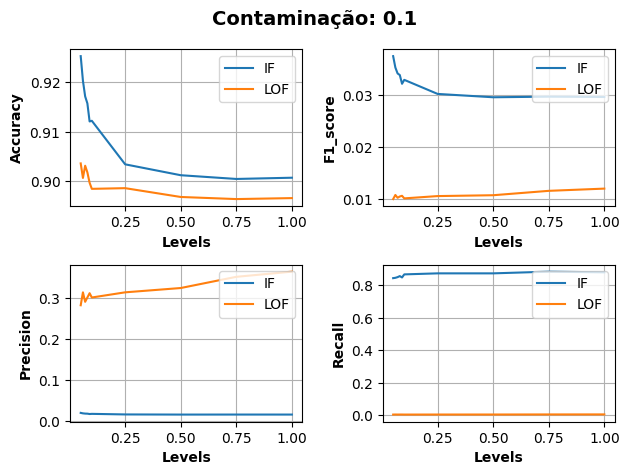

In [47]:
plt.suptitle(f'Contaminação: {contamination[0]}', fontweight='bold', fontsize=14)
plt.subplot(2,2,1)
plt.plot(levels_2, np.mean(metrics_iso[0]['acc'],1))
plt.plot(levels_2, np.mean(metrics_lof[0]['acc'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('Accuracy', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.subplot(2,2,2)
plt.plot(levels_2, np.mean(metrics_iso[0]['f1'],1))
plt.plot(levels_2, np.mean(metrics_lof[0]['f1'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('F1_score', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.subplot(2,2,3)
plt.plot(levels_2, np.mean(metrics_iso[0]['precision'],1))
plt.plot(levels_2, np.mean(metrics_lof[0]['precision'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('Precision', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.subplot(2,2,4)
plt.plot(levels_2, np.mean(metrics_iso[0]['recall'],1))
plt.plot(levels_2, np.mean(metrics_lof[0]['recall'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('Recall', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.savefig("com_0.1.pdf", dpi=300, bbox_inches = 'tight')
plt.tight_layout()
plt.show();

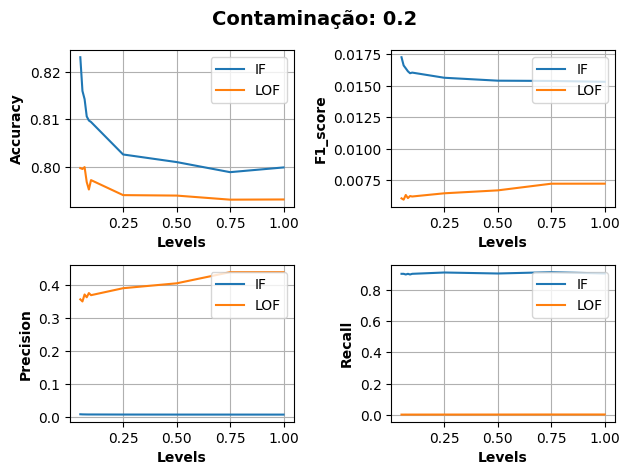

In [48]:
plt.suptitle(f'Contaminação: {contamination[1]}', fontweight='bold', fontsize=14)
plt.subplot(2,2,1)
plt.plot(levels_2, np.mean(metrics_iso[1]['acc'],1))
plt.plot(levels_2, np.mean(metrics_lof[1]['acc'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('Accuracy', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.subplot(2,2,2)
plt.plot(levels_2, np.mean(metrics_iso[1]['f1'],1))
plt.plot(levels_2, np.mean(metrics_lof[1]['f1'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('F1_score', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.subplot(2,2,3)
plt.plot(levels_2, np.mean(metrics_iso[1]['precision'],1))
plt.plot(levels_2, np.mean(metrics_lof[1]['precision'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('Precision', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.subplot(2,2,4)
plt.plot(levels_2, np.mean(metrics_iso[1]['recall'],1))
plt.plot(levels_2, np.mean(metrics_lof[1]['recall'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('Recall', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.savefig("com_0.1.pdf", dpi=300, bbox_inches = 'tight')
plt.tight_layout()
plt.show();

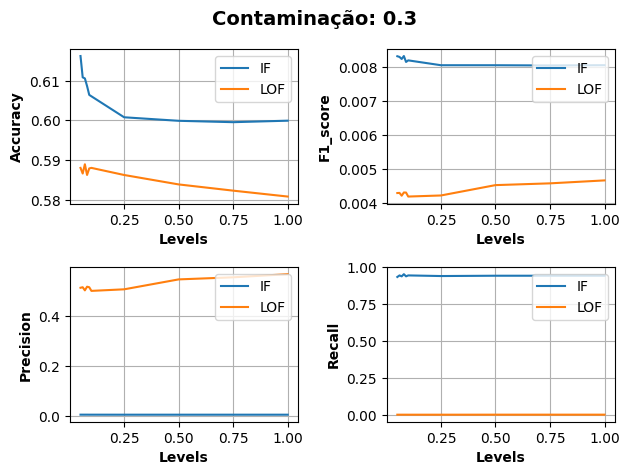

In [49]:
plt.suptitle(f'Contaminação: {contamination[2]}', fontweight='bold', fontsize=14)
plt.subplot(2,2,1)
plt.plot(levels_2, np.mean(metrics_iso[2]['acc'],1))
plt.plot(levels_2, np.mean(metrics_lof[2]['acc'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('Accuracy', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.subplot(2,2,2)
plt.plot(levels_2, np.mean(metrics_iso[2]['f1'],1))
plt.plot(levels_2, np.mean(metrics_lof[2]['f1'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('F1_score', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.subplot(2,2,3)
plt.plot(levels_2, np.mean(metrics_iso[2]['precision'],1))
plt.plot(levels_2, np.mean(metrics_lof[2]['precision'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('Precision', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.subplot(2,2,4)
plt.plot(levels_2, np.mean(metrics_iso[2]['recall'],1))
plt.plot(levels_2, np.mean(metrics_lof[2]['recall'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('Recall', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.savefig("com_0.1.pdf", dpi=300, bbox_inches = 'tight')
plt.tight_layout()
plt.show();

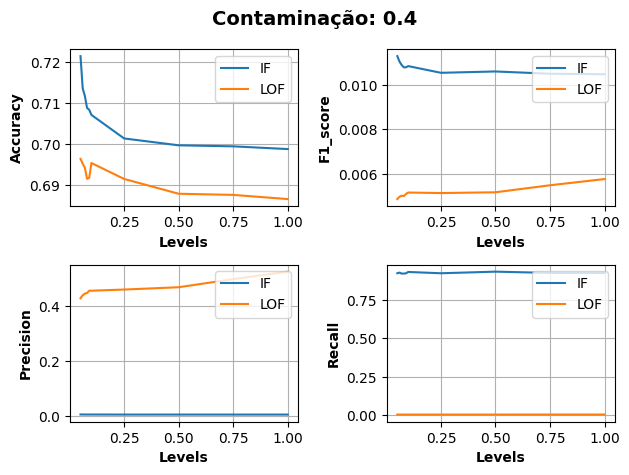

In [50]:
plt.suptitle(f'Contaminação: {contamination[3]}', fontweight='bold', fontsize=14)
plt.subplot(2,2,1)
plt.plot(levels_2, np.mean(metrics_iso[3]['acc'],1))
plt.plot(levels_2, np.mean(metrics_lof[3]['acc'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('Accuracy', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.subplot(2,2,2)
plt.plot(levels_2, np.mean(metrics_iso[3]['f1'],1))
plt.plot(levels_2, np.mean(metrics_lof[3]['f1'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('F1_score', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.subplot(2,2,3)
plt.plot(levels_2, np.mean(metrics_iso[3]['precision'],1))
plt.plot(levels_2, np.mean(metrics_lof[3]['precision'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('Precision', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.subplot(2,2,4)
plt.plot(levels_2, np.mean(metrics_iso[3]['recall'],1))
plt.plot(levels_2, np.mean(metrics_lof[3]['recall'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('Recall', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.savefig("com_0.1.pdf", dpi=300, bbox_inches = 'tight')
plt.tight_layout()
plt.show();

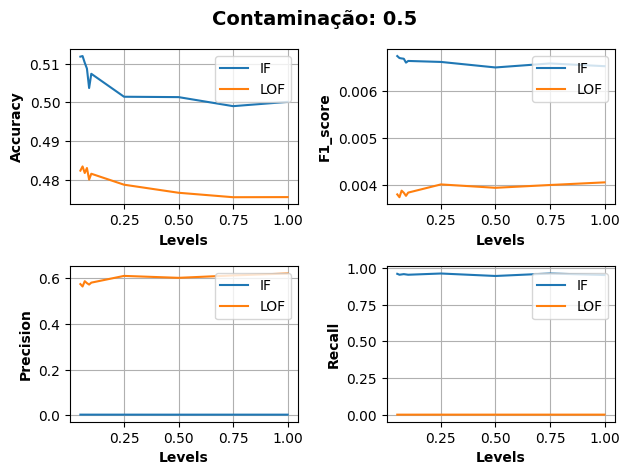

In [51]:
plt.suptitle(f'Contaminação: {contamination[4]}', fontweight='bold', fontsize=14)
plt.subplot(2,2,1)
plt.plot(levels_2, np.mean(metrics_iso[4]['acc'],1))
plt.plot(levels_2, np.mean(metrics_lof[4]['acc'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('Accuracy', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.subplot(2,2,2)
plt.plot(levels_2, np.mean(metrics_iso[4]['f1'],1))
plt.plot(levels_2, np.mean(metrics_lof[4]['f1'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('F1_score', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.subplot(2,2,3)
plt.plot(levels_2, np.mean(metrics_iso[4]['precision'],1))
plt.plot(levels_2, np.mean(metrics_lof[4]['precision'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('Precision', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.subplot(2,2,4)
plt.plot(levels_2, np.mean(metrics_iso[4]['recall'],1))
plt.plot(levels_2, np.mean(metrics_lof[4]['recall'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('Recall', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.savefig("com_0.1.pdf", dpi=300, bbox_inches = 'tight')
plt.tight_layout()
plt.show();

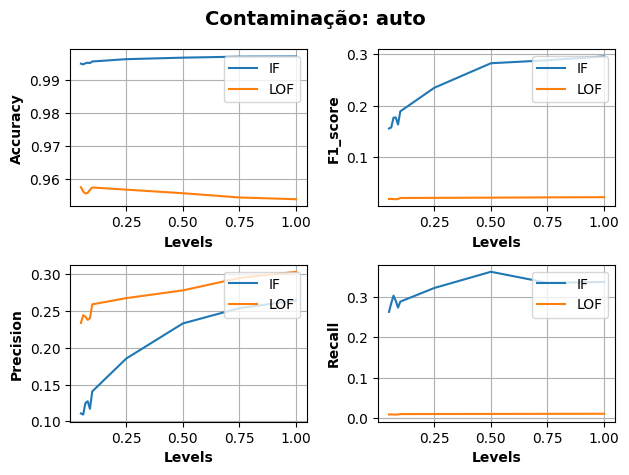

In [52]:
plt.suptitle(f'Contaminação: {contamination[5]}', fontweight='bold', fontsize=14)
plt.subplot(2,2,1)
plt.plot(levels_2, np.mean(metrics_iso[5]['acc'],1))
plt.plot(levels_2, np.mean(metrics_lof[5]['acc'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('Accuracy', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.subplot(2,2,2)
plt.plot(levels_2, np.mean(metrics_iso[5]['f1'],1))
plt.plot(levels_2, np.mean(metrics_lof[5]['f1'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('F1_score', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.subplot(2,2,3)
plt.plot(levels_2, np.mean(metrics_iso[5]['precision'],1))
plt.plot(levels_2, np.mean(metrics_lof[5]['precision'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('Precision', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.subplot(2,2,4)
plt.plot(levels_2, np.mean(metrics_iso[5]['recall'],1))
plt.plot(levels_2, np.mean(metrics_lof[5]['recall'],1))
plt.xlabel('Levels', fontweight='bold', fontsize=10), plt.ylabel('Recall', fontweight='bold', fontsize=10)
plt.legend(
    ['IF',
     'LOF'
    ], loc=1)
plt.grid()
plt.savefig("com_0.1.pdf", dpi=300, bbox_inches = 'tight')
plt.tight_layout()
plt.show();